In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from scipy import stats

In [5]:
from flask import Flask, jsonify

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# measurement_table = Table('measurement', axis, autoload=True, autoload_with=engine)


In [8]:
for class_ in Base.classes:
    print(class_)


<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [9]:
# Create our session (link) from Python to the DB

conn = engine.connect()
station_data = pd.read_sql ("SELECT * FROM station", conn)

print(station_data)

   id      station                                    name  latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US  21.27160   
1   2  USC00513117                    KANEOHE 838.1, HI US  21.42340   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
3   4  USC00517948                       PEARL CITY, HI US  21.39340   
4   5  USC00518838              UPPER WAHIAWA 874.3, HI US  21.49920   
5   6  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
6   7  USC00519281                     WAIHEE 837.5, HI US  21.45167   
7   8  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520   
8   9  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310   

   longitude  elevation  
0 -157.81680        3.0  
1 -157.80150       14.6  
2 -157.83740        7.0  
3 -157.97510       11.9  
4 -158.01110      306.6  
5 -157.71139       19.5  
6 -157.84889       32.9  
7 -157.99920        0.9  
8 -157.80250      152.4  


In [10]:
measurement_data = pd.read_sql ("SELECT * FROM measurement", conn)
print(measurement_data)

          id      station        date  prcp  tobs
0          1  USC00519397  2010-01-01  0.08  65.0
1          2  USC00519397  2010-01-02  0.00  63.0
2          3  USC00519397  2010-01-03  0.00  74.0
3          4  USC00519397  2010-01-04  0.00  76.0
4          5  USC00519397  2010-01-06   NaN  73.0
...      ...          ...         ...   ...   ...
19545  19546  USC00516128  2017-08-19  0.09  71.0
19546  19547  USC00516128  2017-08-20   NaN  78.0
19547  19548  USC00516128  2017-08-21  0.56  76.0
19548  19549  USC00516128  2017-08-22  0.50  76.0
19549  19550  USC00516128  2017-08-23  0.45  76.0

[19550 rows x 5 columns]


In [11]:
session = Session(engine)

In [12]:
start_date = dt.date(2018, 5, 22)
end_date = dt.date(2018, 6, 5)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])
precip_df.set_index('date', inplace = True)
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


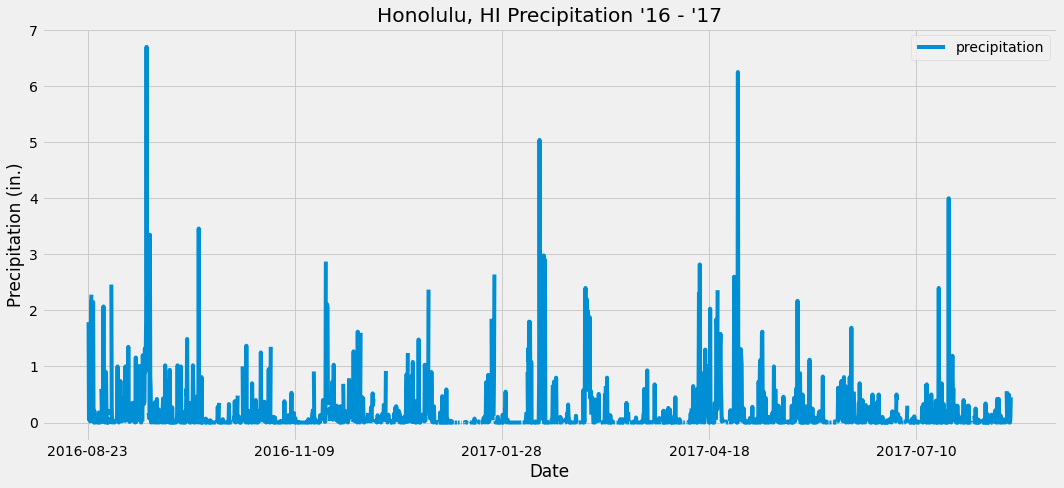

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

#save figure
plt.savefig("precip.png")

#plot figure
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data 
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement.station).distinct().count()
number_stations

9

In [18]:
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

# station_df = pd.DataFrame(active_stations)

# station_df.head()

for row in active_stations:
    print(row[0], row[1])


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_stations.first()[0]

'USC00519281'

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_stations.first()[0]).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


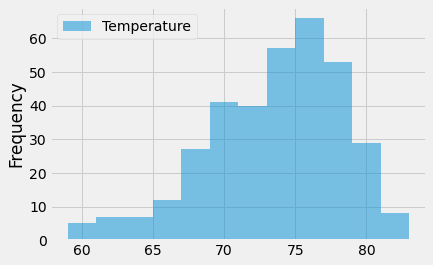

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

all_temps = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations.first()[0]).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

temps_df = pd.DataFrame(all_temps, columns = ['Temperature'])

ax = temps_df.plot.hist(bins=12, alpha=0.5)

# BONUS

# Temperature Analysis I

In [42]:
df = pd.read_csv("hawaii_measurements.csv")

df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [44]:
df.date = pd.to_datetime(df.date,infer_datetime_format=True)
df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [47]:
June_temps = df['date'].map(lambda x: x.month) == 6
June_TAVG = df[June_temps]["tobs"]

June_TAVG.mean()

74.94411764705882

In [48]:
Dec_temps = df['date'].map(lambda x: x.month) == 12
Dec_TAVG = df[Dec_temps]["tobs"]
Dec_TAVG.mean()

71.04152933421226

In [50]:
stats.ttest_ind(June_TAVG, Dec_TAVG)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

# Temperature Analysis II

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [24]:
trip_dates = '2017-05-30 to 2017-06-03'
trip_start_date = '2017-05-30'
trip_end_date = '2017-06-03'
trip_temps = calc_temps(trip_start_date, trip_end_date)
trip_temps

[(72.0, 77.41379310344827, 81.0)]

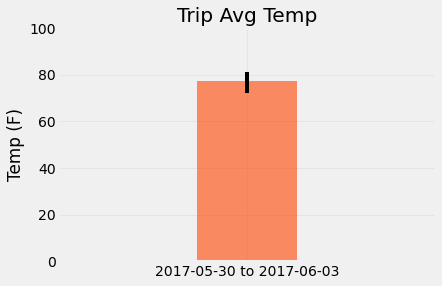

In [26]:
TMIN = trip_temps[0][0]
TAVG = trip_temps[0][1]
TMAX = trip_temps[0][2]

minplt = TAVG - TMIN
maxplt = TMAX - TAVG

YERR = np.array([[minplt], [maxplt]])

plt.bar(trip_dates, TAVG, yerr=YERR, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

# Daily Rainfall Average

In [56]:
#Calculate the rainfall per weather station using the previous year's matching dates.
yearly_rain = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
rain_df = pd.DataFrame(yearly_rain, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

rain_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


In [51]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("05-31")

[(68.0, 74.4, 81.0)]

In [52]:
trip_days = ["05-30", "05-31", "06-01", "06-02", "06-03"]

In [58]:
daily_norms = []

for trip_days in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': None, 'Max': None},
 {'Date': '2019-3', 'Min': None, 'Avg': 

In [ ]:
#plot
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynormarea.png')

#show
plt.grid()
plt.tight_layout()
plt.show()